In [2]:
import os
import sys

nb_dir = os.path.split(os.path.split(os.getcwd())[0])[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

from jaxsnn.functional.leaky_integrator import LIParameters, LIState

In [41]:
import diffrax
from diffrax import diffeqsolve, ODETerm, Dopri5
import jax.numpy as np
from diffrax import diffeqsolve, Dopri5, ODETerm, SaveAt, PIDController
import jax

In [36]:
# express our ODEs
p = LIParameters()

def li_dt(t, y, args):
    dv_dt = p.tau_mem_inv *(p.v_leak - y["v"] + y["i"])
    di_dt = -p.tau_syn_inv * y["i"]
    return {
        "v": dv_dt,
        "i": di_dt,
    }



In [76]:
y0 = {"v": 1.0, "i": 1.0}
dt0 = 5e-4

term = ODETerm(li_dt)
solver = Dopri5()
stepsize_controller = PIDController(rtol=1e-5, atol=1e-5)

spike_times = dt0 * 10 * np.arange(1, 10)  # type: ignore
y0 = {"v": 0.0, "i": 0.0}
prev_time = 0.0
res = {
    "i": np.array([]),
    "v": np.array([]),
}
t = np.array([])

for t1 in spike_times:
    y0["i"] += 1.0
    ts = np.arange(prev_time, t1 - 1e-7, dt0)
    saveat = SaveAt(ts=ts)
    sol = diffeqsolve(term, solver=solver, t0=prev_time, t1=t1, dt0=dt0, y0=y0, saveat=saveat,
                  stepsize_controller=stepsize_controller)
    y0=jax.tree_map(lambda x: x[-1], sol.ys)

    res = jax.tree_map(lambda x, y: np.concatenate((x, y)), res, sol.ys)
    t = np.concatenate((t, ts))
    prev_time = t1

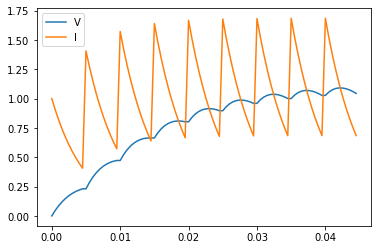

In [77]:
import matplotlib.pyplot as plt
plt.plot(t, res["v"], label="V")
plt.plot(t, res["i"], label="I")
plt.legend()

In [56]:
sol.ys["i"]

DeviceArray([], dtype=float32, weak_type=True)

In [9]:
from jax.lax import custom_root, custom_linear_solve
from jax.scipy.linalg import solve
import jax.numpy as np

initial_guess = 2.0

def f(x):
    return x ** 2 + x + 0

def tangent_solve(g, y):
    return y / g(1.0)


# def solve(f, inital_guess):
#     return linalg.solve

sol = custom_root(f, initial_guess, solve, tangent_solve)
f(sol)


TypeError: Argument '<function f at 0x2866267a0>' of type <class 'function'> is not a valid JAX type.

In [ ]:
def f()